In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import itertools
from itertools import product
import warnings
warnings.filterwarnings("ignore") 

In [2]:
data = pd.read_csv('../data/regional_univariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [3]:
# Split the datasets

def prepare_and_split_data(data, test_size = 0.15):
    data = data.sort_values('date')
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))

Length enc train:  822
Length enc test:  146


In [22]:
def arima_search(train, test, p_range = range(0,8), d_range = range(0,1), q_range = range(0, 8), log_transform = 'False'):
    scores = []
    params = list(itertools.product(p_range, d_range, q_range))
    
    for combination in params:
        model = ARIMA(train['new_confirmed'], order = combination)
        model = model.fit()
        forecast = model.forecast(steps=len(test))
        mase_score = mean_absolute_scaled_error(test['new_confirmed'], forecast, y_train=train['new_confirmed'])
        scores.append((combination, mase_score))

    best_params, best_mase = min(scores, key=lambda x: x[1])

    # combined_data = pd.concat([train['new_confirmed'], test['new_confirmed']])

    best_model = ARIMA(train['new_confirmed'], order=best_params)
    best_model_fit = best_model.fit()
    
    print(best_model_fit.summary())

    forecast = best_model_fit.forecast(steps=len(test))
    test_data = test['new_confirmed']

    print(f"Best Model: ARIMA{best_params} with MASE {best_mase}")
    mae = mean_absolute_error(test['new_confirmed'], forecast)
    print(f"Best MAE {mae}")
    rmse = np.sqrt(mean_squared_error(test['new_confirmed'], forecast))
    print(f"Best RMSE {rmse}")



    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label='New Cases')
    plt.plot(test_data.index, forecast, label='Predicted New Cases', alpha=0.7)
    plt.title('Actual and Predicted Daily New Cases')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

    return best_params, best_mase


In [94]:
def log_transform(x):
    return np.log(x) if x > 0 else 0

def prepare_data(data):
    data = data[['date', 'new_confirmed']].copy() 
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    data.index = pd.to_datetime(data.index)
    data['new_confirmed'] = data['new_confirmed'].apply(lambda x: log_transform(x))
    return data


datasets = [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]
processed_datasets = [prepare_data(df) for df in datasets]
enc, esc, midatl, mount, ne, pac, satl, wnc, wsc = processed_datasets
enc

,new_confirmed
date,
2020-01-22,0.000000
2020-01-23,0.000000
2020-01-24,0.000000
2020-01-25,0.000000
2020-01-26,0.000000
...,...
2022-09-11,0.000000
2022-09-12,9.357466
2022-09-13,9.537411


# East North Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                 ARIMA(7, 0, 9)   Log Likelihood               -8667.087
Date:                Fri, 01 Mar 2024   AIC                          17370.174
Time:                        23:49:01   BIC                          17454.985
Sample:                             0   HQIC                         17402.713
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.401e+04   1.41e+04      0.990      0.322   -1.37e+04    4.17e+04
ar.L1         -0.0109      0.011     -1.007      0.314      -0.032       0.010
ar.L2          0.0073      0.010      0.701      0.4

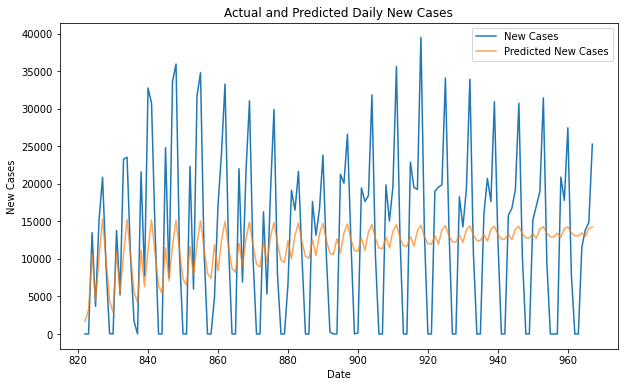

In [24]:
enc_params, enc_mase = arima_search(enc_train, enc_test, p_range = [1, 2 ,7], q_range = [7, 8, 9, 10, 11, 14, 19, 21, 28])

In [96]:
p = range(8)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(enc_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)


          Order          AIC
0    (7, 0, 19)  1971.479523
1    (7, 0, 14)  1973.597528
2    (7, 0, 18)  1976.989925
3    (7, 0, 16)  1982.239873
4    (7, 0, 17)  1983.764264
..          ...          ...
171   (1, 0, 0)  2926.611109
172   (0, 0, 3)  2983.690477
173   (0, 0, 2)  3150.062413
174   (0, 0, 1)  3295.158402
175   (0, 0, 0)  3866.948305

[176 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 19)   Log Likelihood                -957.740
Date:                Wed, 21 Feb 2024   AIC                           1971.480
Time:                        23:01:56   BIC                           2103.408
Sample:                    01-22-2020   HQIC                          2022.096
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1885    482.278      0.017      0.986    -937.058     953.435
ar.L1          0.0066      0.019      0.351      0.726      -0.030       0.044
ar.L2          0.0088      0.024      0.369      0.7

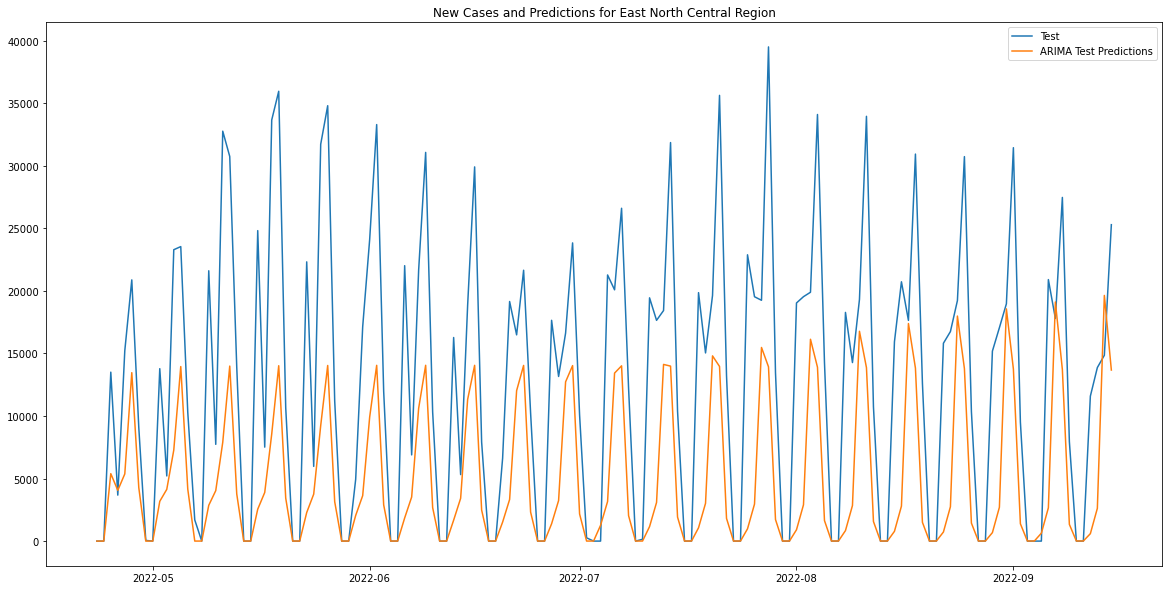

In [97]:
best_order = scores[0][0]

best_model = ARIMA(enc_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(enc_train)
end = start + len(enc_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(enc_train.index), np.exp(np.array(enc_train['new_confirmed'])), label='Train')
# plt.plot(np.array(enc_train.index), np.exp(np.array(train_predictions)), label='ARIMA Train Predictions')
plt.plot(np.array(enc_test.index), np.exp(np.array(enc_test['new_confirmed'])), label='Test')
plt.plot(np.array(enc_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# East South Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 14)   Log Likelihood               -8201.118
Date:                Fri, 01 Mar 2024   AIC                          16448.236
Time:                        23:51:42   BIC                          16556.606
Sample:                             0   HQIC                         16489.813
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6590.0073   6850.014      0.962      0.336   -6835.773       2e+04
ar.L1          0.1217      0.149      0.820      0.412      -0.169       0.413
ar.L2          0.1334      0.138      0.965      0.3

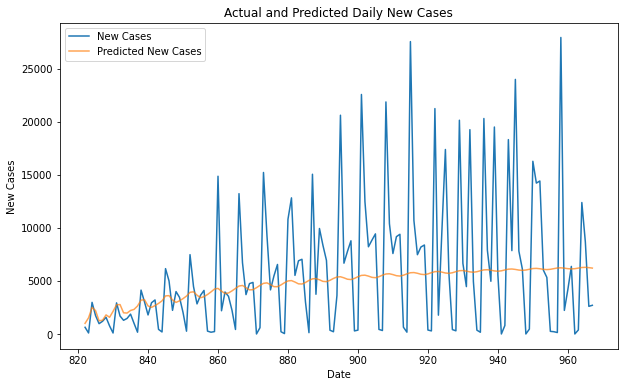

In [26]:
esc_params, esc_mase = arima_search(esc_train, esc_test, p_range = [0, 1, 2, 3,7], q_range = [0, 1, 2, 3, 4, 5, 6, 7, 14, 21])

In [98]:
p = range(8)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(esc_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

          Order          AIC
0    (7, 0, 12)  1879.665395
1    (7, 0, 13)  1882.606771
2    (7, 0, 20)  1882.645197
3    (7, 0, 21)  1887.444697
4    (7, 0, 15)  1888.777971
..          ...          ...
171   (0, 0, 4)  2679.304544
172   (0, 0, 3)  2836.580291
173   (0, 0, 2)  2983.951590
174   (0, 0, 1)  3239.456930
175   (0, 0, 0)  3796.843813

[176 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                 ARIMA(7, 0, 7)   Log Likelihood                -934.824
Date:                Wed, 21 Feb 2024   AIC                           1901.648
Time:                        23:10:34   BIC                           1977.036
Sample:                    01-22-2020   HQIC                          1930.572
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3651    102.309      0.072      0.943    -193.156     207.886
ar.L1         -0.0042      0.009     -0.469      0.639      -0.022       0.013
ar.L2          0.0007      0.012      0.058      0.9

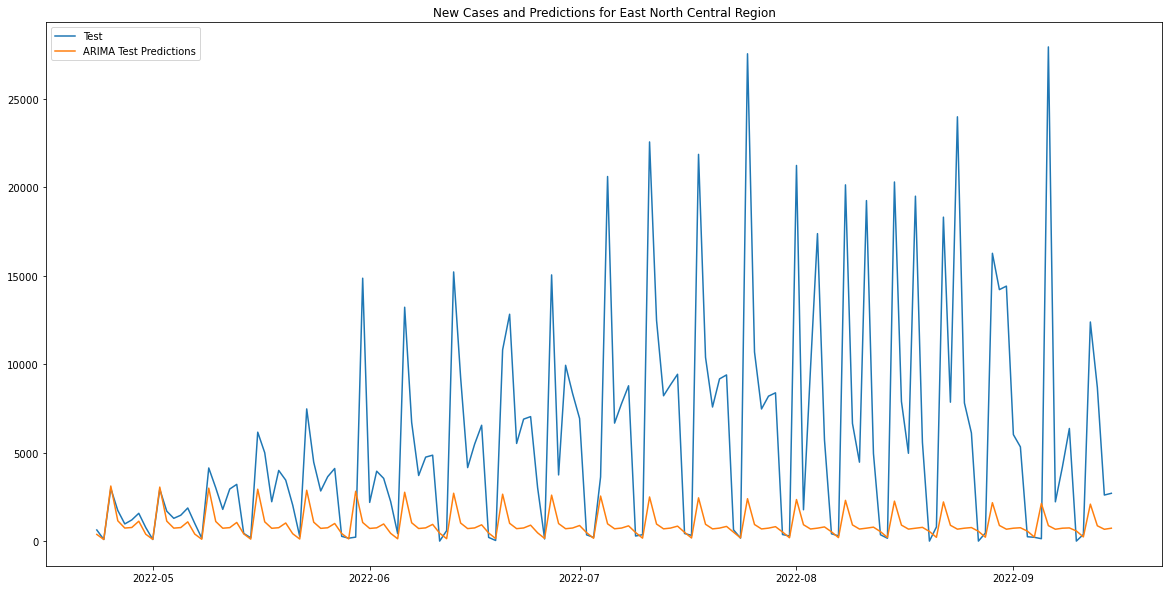

In [99]:
best_order = scores[0][0]

best_model = ARIMA(esc_train['new_confirmed'], order=(7,0,7))
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(esc_train)
end = start + len(esc_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(esc_train.index), np.array(esc_train['new_confirmed']), label='Train')
# plt.plot(np.array(esc_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(esc_test.index), np.exp(np.array(esc_test['new_confirmed'])), label='Test')
plt.plot(np.array(esc_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# Mid-Atlantic

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(9, 0, 12)   Log Likelihood               -8023.238
Date:                Sat, 02 Mar 2024   AIC                          16092.476
Time:                        00:02:35   BIC                          16200.846
Sample:                             0   HQIC                         16134.054
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.232e+04   8549.500      1.440      0.150   -4441.309    2.91e+04
ar.L1          0.4597      0.070      6.552      0.000       0.322       0.597
ar.L2          0.0695      0.079      0.876      0.3

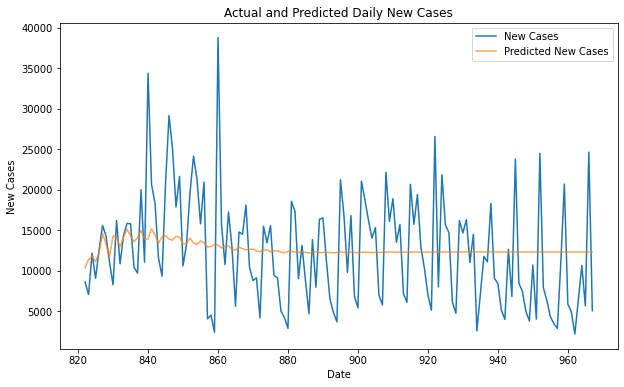

In [29]:
ma_params, ma_mase = arima_search(midatl_train, midatl_test, p_range = [0, 1, 2, 8, 9], q_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [100]:
p = range(4)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(midatl_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

         Order          AIC
0   (3, 0, 12)  1004.577258
1    (3, 0, 9)  1005.504949
2   (3, 0, 10)  1005.561355
3   (3, 0, 11)  1006.909323
4   (3, 0, 13)  1008.494227
..         ...          ...
83   (0, 0, 4)  1933.656671
84   (0, 0, 3)  2146.349472
85   (0, 0, 2)  2435.483726
86   (0, 0, 1)  2912.686686
87   (0, 0, 0)  3732.063335

[88 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(3, 0, 12)   Log Likelihood                -485.289
Date:                Wed, 21 Feb 2024   AIC                           1004.577
Time:                        23:14:14   BIC                           1084.677
Sample:                    01-22-2020   HQIC                          1035.308
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4131    275.250      0.027      0.979    -532.068     546.894
ar.L1          2.2445      0.006    365.131      0.000       2.232       2.257
ar.L2         -2.2400      0.011   -196.661      0.0

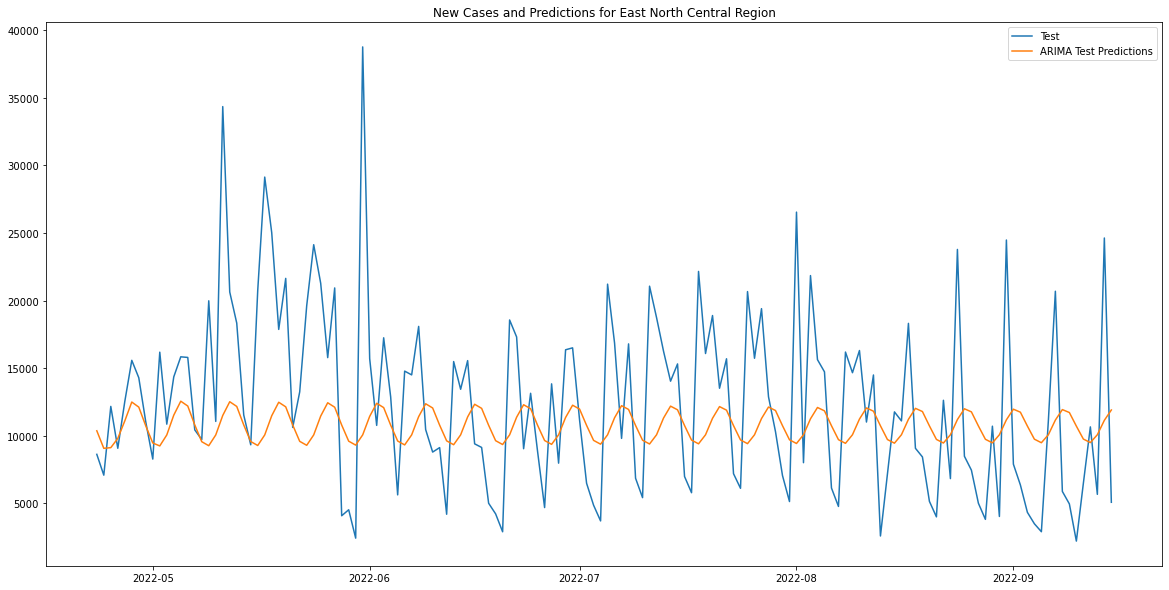

In [101]:
best_order = scores[0][0]

best_model = ARIMA(midatl_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(midatl_train)
end = start + len(midatl_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(midatl_train.index), np.array(midatl_train['new_confirmed']), label='Train')
# plt.plot(np.array(midatl_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(midatl_test.index), np.exp(np.array(midatl_test['new_confirmed'])), label='Test')
plt.plot(np.array(midatl_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# Mountain

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                 ARIMA(9, 0, 7)   Log Likelihood               -8245.654
Date:                Sat, 02 Mar 2024   AIC                          16527.307
Time:                        00:12:31   BIC                          16612.118
Sample:                             0   HQIC                         16559.846
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7838.9416   9.41e-05   8.33e+07      0.000    7838.941    7838.942
ar.L1          1.4454      0.868      1.665      0.096      -0.256       3.146
ar.L2         -0.7984      2.030     -0.393      0.6

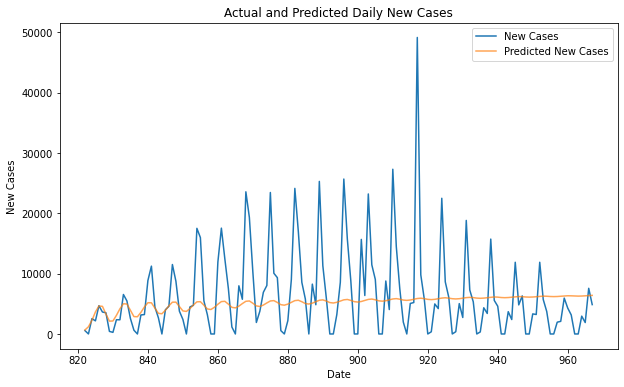

In [30]:
mount_params, mount_mase = arima_search(mount_train, mount_test, p_range = [0, 1, 2, 3, 6, 7, 9, 10, 21], q_range = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21])

In [102]:
p = range(8)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(mount_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

          Order          AIC
0    (7, 0, 21)   989.631180
1    (7, 0, 15)   995.411553
2    (7, 0, 14)   998.021302
3    (7, 0, 17)   998.230227
4    (7, 0, 18)   999.909330
..          ...          ...
171   (0, 0, 4)  2275.064831
172   (0, 0, 3)  2479.494992
173   (0, 0, 2)  2622.825117
174   (0, 0, 1)  3015.256342
175   (0, 0, 0)  3732.528321

[176 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 21)   Log Likelihood                -469.929
Date:                Wed, 21 Feb 2024   AIC                            999.857
Time:                        23:23:19   BIC                           1141.209
Sample:                    01-22-2020   HQIC                          1054.089
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2593      6.685      1.236      0.217      -4.843      21.361
ar.L1          0.8726      0.430      2.031      0.042       0.030       1.715
ar.L2          0.4435      0.434      1.023      0.3

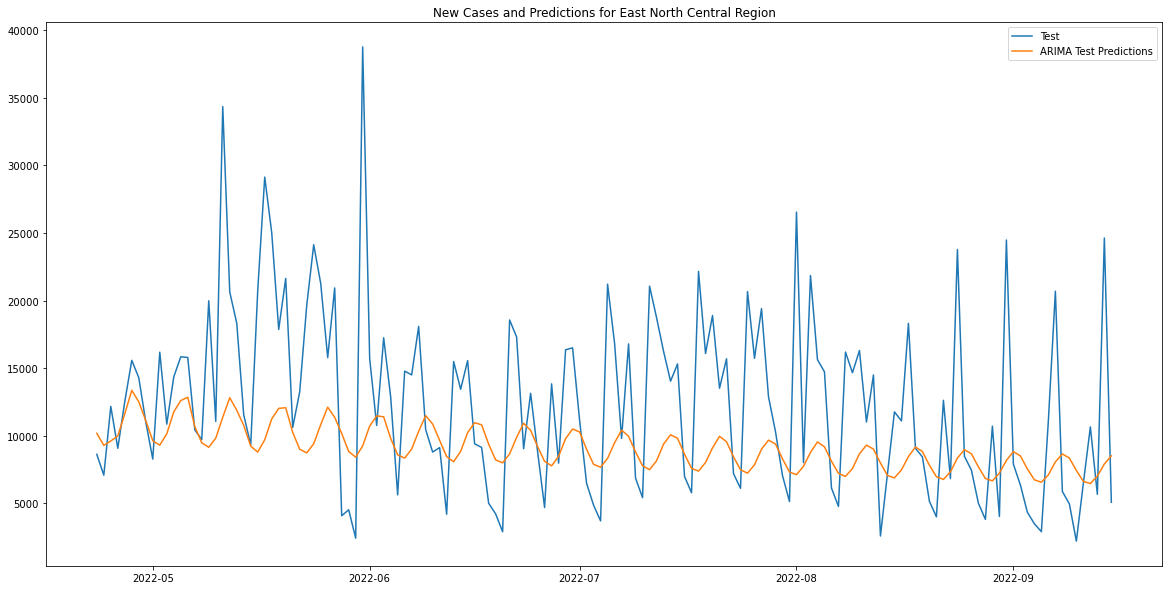

In [103]:
best_order = scores[0][0]

best_model = ARIMA(midatl_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(midatl_train)
end = start + len(midatl_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(midatl_train.index), np.array(midatl_train['new_confirmed']), label='Train')
# plt.plot(np.array(midatl_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(midatl_test.index), np.exp(np.array(midatl_test['new_confirmed'])), label='Test')
plt.plot(np.array(midatl_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# New England

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(10, 0, 7)   Log Likelihood               -8061.466
Date:                Sat, 02 Mar 2024   AIC                          16160.931
Time:                        00:18:29   BIC                          16250.454
Sample:                             0   HQIC                         16195.278
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4294.0669   4087.857      1.050      0.294   -3717.986    1.23e+04
ar.L1         -0.1561      0.053     -2.921      0.003      -0.261      -0.051
ar.L2          0.3069      0.045      6.770      0.0

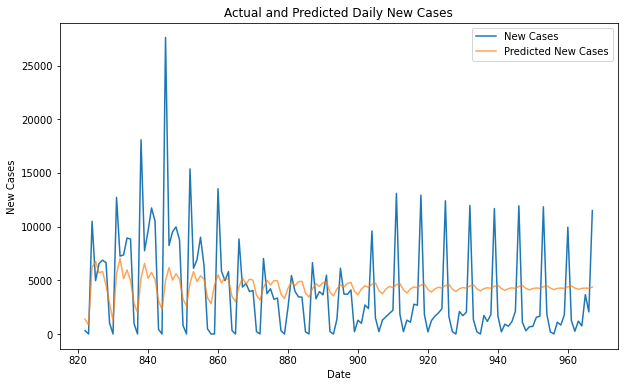

In [31]:
ne_params, ne_mase = arima_search(ne_train, ne_test, p_range = [0, 1, 3, 6, 7, 10], q_range = [0, 1, 3, 4, 6, 7, 8, 14, 21])

In [104]:
p = range(15)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(mount_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

           Order          AIC
0     (13, 0, 9)   985.626576
1     (12, 0, 9)   988.887020
2    (12, 0, 10)   989.422644
3     (7, 0, 21)   989.631180
4    (13, 0, 14)   989.742948
..           ...          ...
325    (0, 0, 4)  2275.064831
326    (0, 0, 3)  2479.494992
327    (0, 0, 2)  2622.825117
328    (0, 0, 1)  3015.256342
329    (0, 0, 0)  3732.528321

[330 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(13, 0, 9)   Log Likelihood                -472.318
Date:                Wed, 21 Feb 2024   AIC                            992.637
Time:                        23:44:02   BIC                           1105.719
Sample:                    01-22-2020   HQIC                          1036.022
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2466      5.132      1.607      0.108      -1.812      18.306
ar.L1          0.5077      1.551      0.327      0.743      -2.533       3.548
ar.L2          0.8884      2.266      0.392      0.6

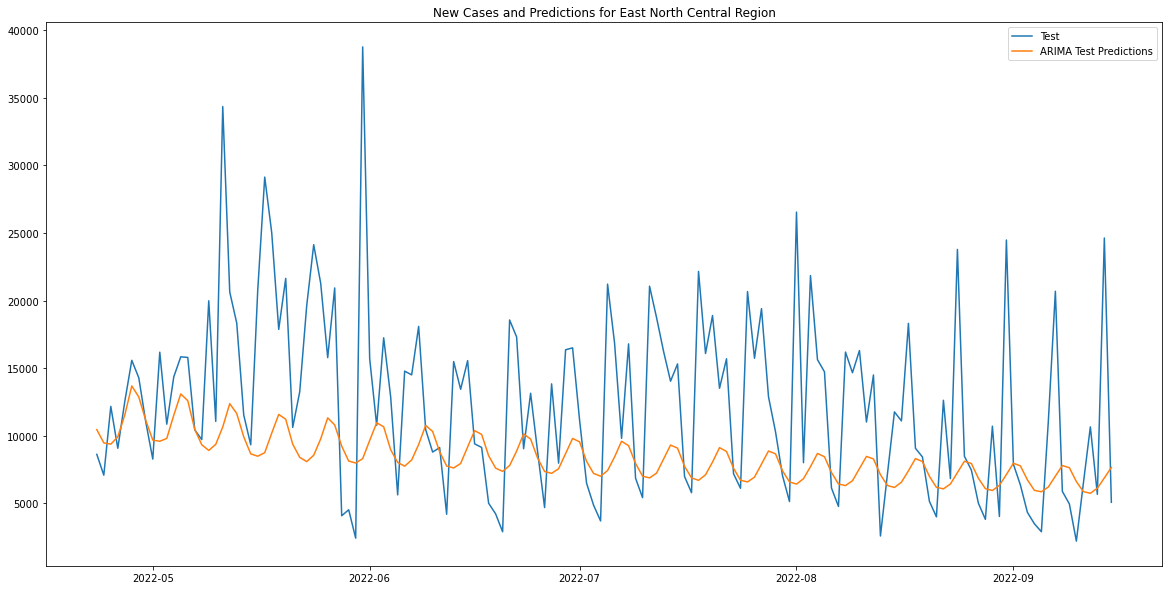

In [105]:
best_order = scores[0][0]

best_model = ARIMA(midatl_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(midatl_train)
end = start + len(midatl_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(midatl_train.index), np.array(midatl_train['new_confirmed']), label='Train')
# plt.plot(np.array(midatl_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(midatl_test.index), np.exp(np.array(midatl_test['new_confirmed'])), label='Test')
plt.plot(np.array(midatl_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# Pacific

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(10, 0, 3)   Log Likelihood               -8815.072
Date:                Sat, 02 Mar 2024   AIC                          17660.145
Time:                        00:28:28   BIC                          17730.821
Sample:                             0   HQIC                         17687.260
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.432e+04   4.19e-07   3.41e+10      0.000    1.43e+04    1.43e+04
ar.L1          0.1403      0.070      2.017      0.044       0.004       0.277
ar.L2          0.2775      0.057      4.896      0.0

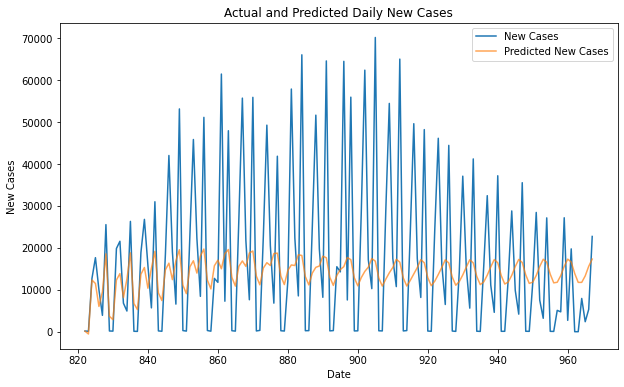

In [33]:
pac_params, pac_mase = arima_search(pac_train, pac_test, p_range = [0, 1, 3, 7, 9, 10], q_range = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

In [106]:
p = range(15)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(pac_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

           Order          AIC
0    (13, 0, 12)  1503.455796
1     (14, 0, 8)  1503.634876
2     (8, 0, 21)  1505.598023
3     (14, 0, 9)  1505.733285
4     (7, 0, 16)  1506.568595
..           ...          ...
325    (0, 0, 4)  2513.577002
326    (0, 0, 3)  2615.635460
327    (0, 0, 2)  2792.816213
328    (0, 0, 1)  3073.600793
329    (0, 0, 0)  3709.056142

[330 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(13, 0, 12)   Log Likelihood                -724.728
Date:                Thu, 22 Feb 2024   AIC                           1503.456
Time:                        00:04:24   BIC                           1630.673
Sample:                    01-22-2020   HQIC                          1552.264
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2857      2.765      2.997      0.003       2.867      13.704
ar.L1         -0.0205      0.834     -0.025      0.980      -1.656       1.615
ar.L2          0.1421      0.332      0.428      0.6

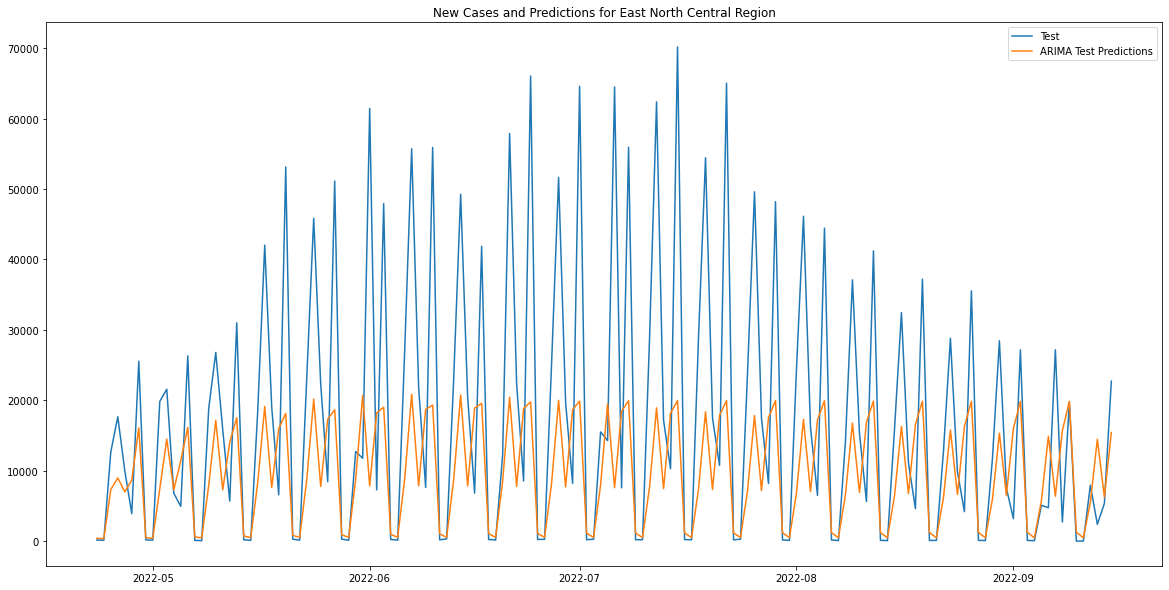

In [107]:
best_order = scores[0][0]

best_model = ARIMA(pac_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(pac_train)
end = start + len(pac_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(pac_train.index), np.array(pac_train['new_confirmed']), label='Train')
# plt.plot(np.array(pac_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(pac_test.index), np.exp(np.array(pac_test['new_confirmed'])), label='Test')
plt.plot(np.array(pac_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# South Atlantic

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(13, 0, 12)   Log Likelihood               -9118.429
Date:                Sat, 02 Mar 2024   AIC                          18290.857
Time:                        00:34:39   BIC                          18418.074
Sample:                             0   HQIC                         18339.666
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.955e+04   1.05e+04      1.855      0.064   -1105.881    4.02e+04
ar.L1         -0.4863      0.050     -9.737      0.000      -0.584      -0.388
ar.L2          0.0414      0.088      0.469      0.6

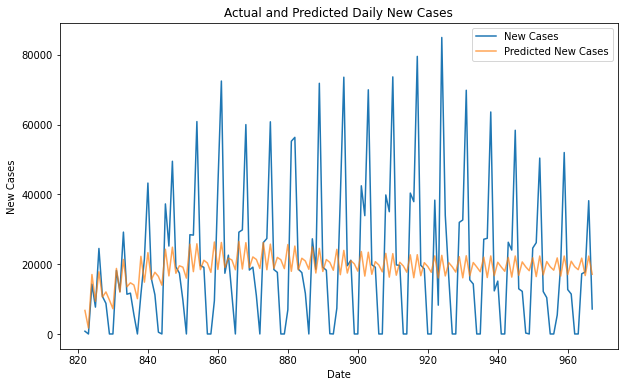

In [34]:
satl_params, satl_mase = arima_search(satl_train, satl_test, p_range = [0, 1, 6, 7, 12, 13], q_range = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

In [108]:
p = range(15)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(satl_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

           Order          AIC
0     (8, 0, 13)  2013.813774
1     (9, 0, 15)  2014.446029
2     (8, 0, 14)  2014.646348
3     (8, 0, 15)  2016.835904
4    (11, 0, 12)  2019.864896
..           ...          ...
325    (0, 0, 4)  2866.364264
326    (0, 0, 3)  2971.381766
327    (0, 0, 2)  3085.226478
328    (0, 0, 1)  3302.971112
329    (0, 0, 0)  3880.343251

[330 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(8, 0, 13)   Log Likelihood                -983.907
Date:                Thu, 22 Feb 2024   AIC                           2013.814
Time:                        00:24:32   BIC                           2122.184
Sample:                    01-22-2020   HQIC                          2055.391
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5449      4.064      2.103      0.036       0.579      16.510
ar.L1          0.6544      0.162      4.034      0.000       0.336       0.972
ar.L2         -0.0023      0.026     -0.089      0.9

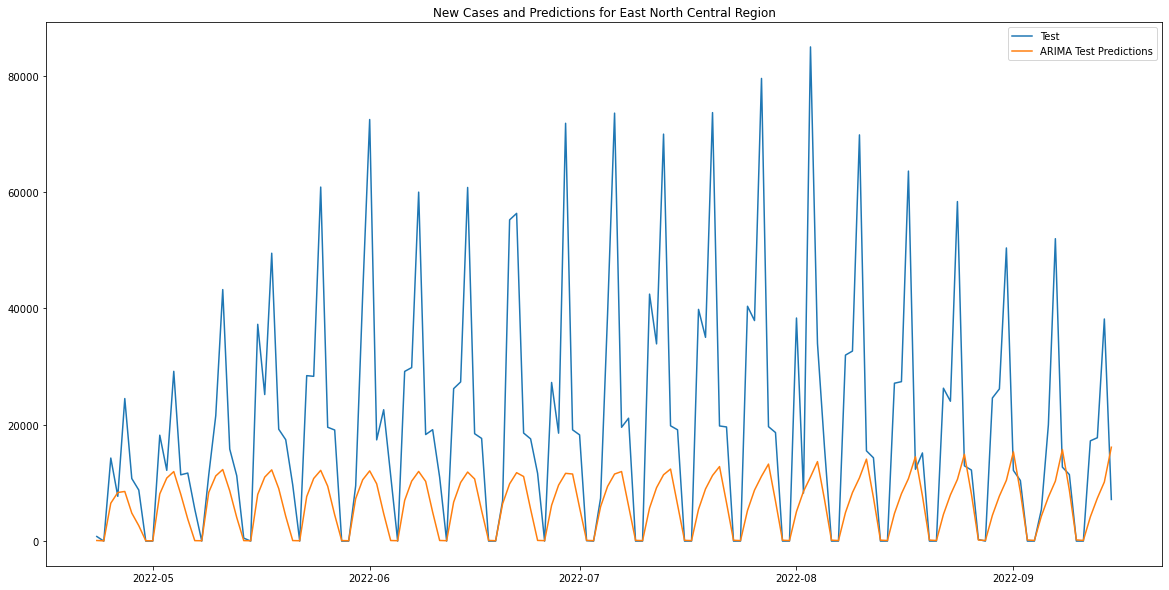

In [109]:
best_order = scores[0][0]

best_model = ARIMA(satl_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(satl_train)
end = start + len(satl_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(satl_train.index), np.array(satl_train['new_confirmed']), label='Train')
# plt.plot(np.array(satl_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(satl_test.index), np.exp(np.array(satl_test['new_confirmed'])), label='Test')
plt.plot(np.array(satl_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# West North Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                 ARIMA(7, 0, 9)   Log Likelihood               -8137.897
Date:                Sat, 02 Mar 2024   AIC                          16311.794
Time:                        00:38:38   BIC                          16396.605
Sample:                             0   HQIC                         16344.333
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6400.6423   5273.227      1.214      0.225   -3934.692    1.67e+04
ar.L1          0.0142      0.026      0.540      0.589      -0.037       0.066
ar.L2         -0.0090      0.030     -0.299      0.7

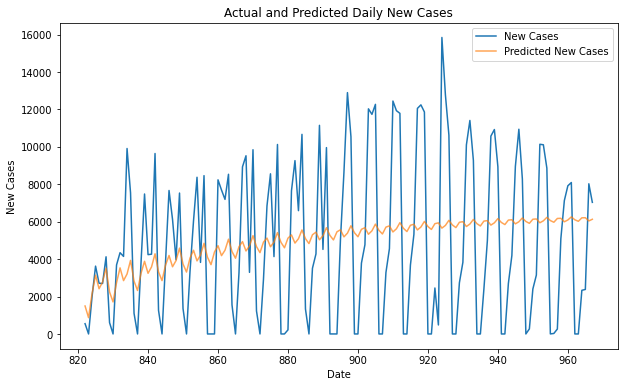

In [35]:
wnc_params, wnc_mase = arima_search(wnc_train, wnc_test, p_range = [0, 1, 5, 6, 7], q_range = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

In [110]:
p = range(15)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(wnc_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

           Order          AIC
0    (14, 0, 13)  1536.813635
1     (9, 0, 11)  1536.945717
2     (9, 0, 13)  1537.203418
3    (11, 0, 11)  1537.293554
4    (12, 0, 11)  1538.276137
..           ...          ...
325    (0, 0, 4)  2535.091035
326    (0, 0, 3)  2690.269692
327    (0, 0, 2)  2824.808144
328    (0, 0, 1)  3103.712738
329    (0, 0, 0)  3728.293148

[330 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(14, 0, 13)   Log Likelihood                -739.407
Date:                Thu, 22 Feb 2024   AIC                           1536.814
Time:                        00:44:51   BIC                           1673.454
Sample:                    01-22-2020   HQIC                          1589.237
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6055      1.613      4.715      0.000       4.444      10.767
ar.L1         -0.5408      0.160     -3.381      0.001      -0.854      -0.227
ar.L2         -0.1580      0.174     -0.909      0.3

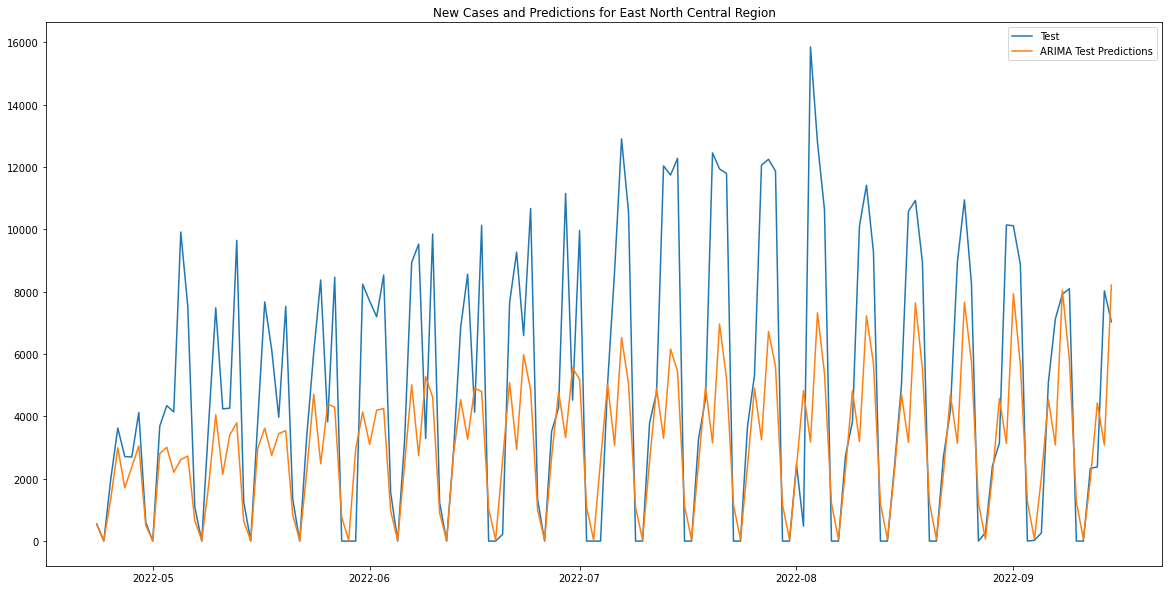

In [111]:
best_order = scores[0][0]

best_model = ARIMA(wnc_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(wnc_train)
end = start + len(wnc_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(wnc_train.index), np.array(wnc_train['new_confirmed']), label='Train')
# plt.plot(np.array(wnc_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(wnc_test.index), np.exp(np.array(wnc_test['new_confirmed'])), label='Test')
plt.plot(np.array(wnc_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()

# West South Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 14)   Log Likelihood               -8570.401
Date:                Sat, 02 Mar 2024   AIC                          17186.803
Time:                        00:42:10   BIC                          17295.173
Sample:                             0   HQIC                         17228.380
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.197e+04   9514.903      1.258      0.208   -6679.940    3.06e+04
ar.L1          0.2812      0.089      3.145      0.002       0.106       0.456
ar.L2         -0.0233      0.089     -0.263      0.7

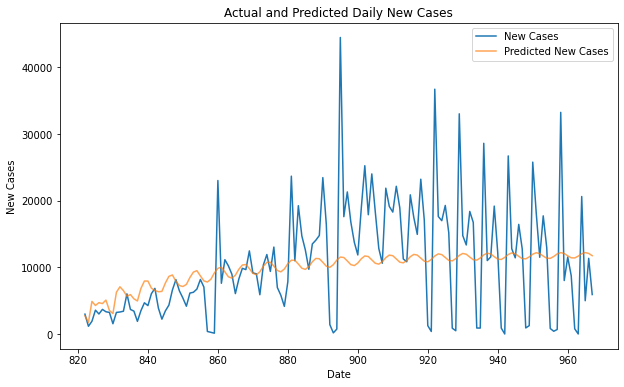

In [36]:
wsc_params, wsc_mase = arima_search(wsc_train, wsc_test, p_range = [0, 1, 2, 7], q_range = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

In [112]:
p = range(15)
q = range(22)
d = [0]

orders = list(product(p, d, q))

scores = []

for order in orders:
    model = ARIMA(wsc_train['new_confirmed'], order = order)
    fitted_model = model.fit()
    scores.append((order, fitted_model.aic))

scores = sorted(scores, key = lambda x: x[1])

scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
print(scores_df)

          Order          AIC
0    (9, 0, 11)  1142.469650
1    (8, 0, 10)  1144.025533
2     (9, 0, 8)  1144.623236
3    (9, 0, 10)  1144.964781
4    (8, 0, 11)  1147.025487
..          ...          ...
325   (0, 0, 4)  2113.037731
326   (0, 0, 3)  2424.681414
327   (0, 0, 2)  2514.058860
328   (0, 0, 1)  2957.953340
329   (0, 0, 0)  3727.503230

[330 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(9, 0, 11)   Log Likelihood                -549.235
Date:                Thu, 22 Feb 2024   AIC                           1142.470
Time:                        01:05:31   BIC                           1246.128
Sample:                    01-22-2020   HQIC                          1182.239
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2183      2.666      3.083      0.002       2.993      13.443
ar.L1          0.1786      0.312      0.573      0.567      -0.433       0.790
ar.L2          0.6608      0.295      2.244      0.0

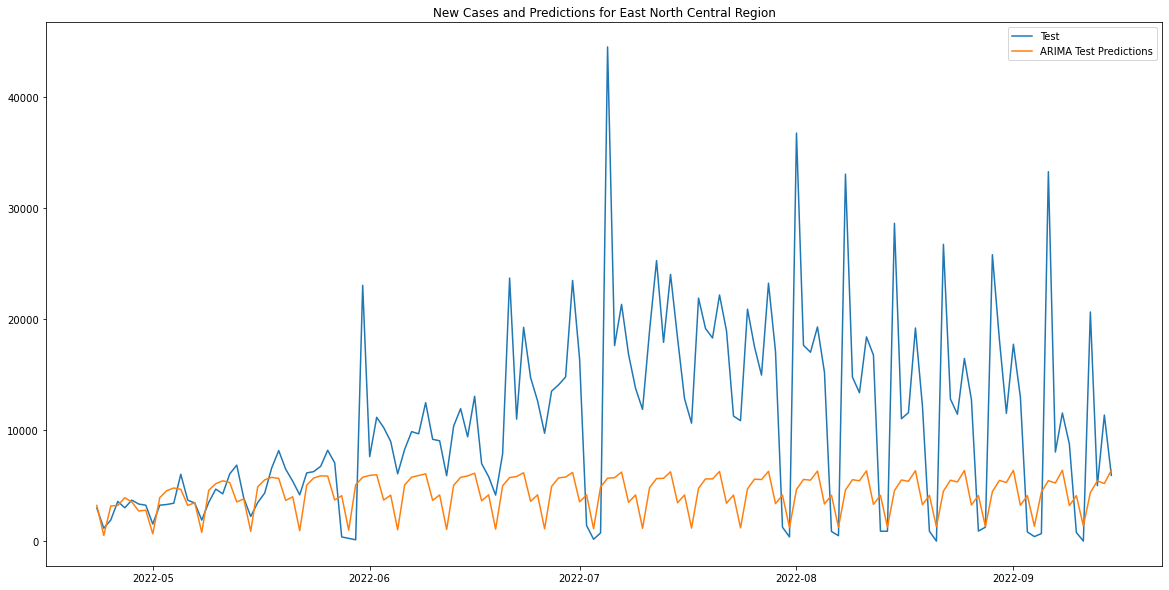

In [113]:
best_order = scores[0][0]

best_model = ARIMA(wsc_train['new_confirmed'], order=best_order)
best_model_fit = best_model.fit()

print(best_model_fit.summary())

start = len(wsc_train)
end = start + len(wsc_test) - 1
test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')
train_predictions = best_model_fit.predict(start=1, end=start, typ='levels')

plt.figure(figsize=(20, 10))
# plt.plot(np.array(wsc_train.index), np.array(wsc_train['new_confirmed']), label='Train')
# plt.plot(np.array(wsc_train.index), np.array(train_predictions), label='ARIMA Train Predictions')
plt.plot(np.array(wsc_test.index), np.exp(np.array(wsc_test['new_confirmed'])), label='Test')
plt.plot(np.array(wsc_test.index), np.exp(np.array(test_predictions)), label='ARIMA Test Predictions')
plt.title("New Cases and Predictions for East North Central Region")
plt.legend()
plt.show()